In [1]:
from typing import List
from itertools import combinations
import numpy as np
import dask.dataframe as dd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
dir = "./data/tree/inverse/precedence/"
real = dd.read_parquet(dir+"main.parquet", columns=["spec","variant","real.tests", "real.downs", "size", "clocks"])
squished = dd.read_parquet(dir+"squished.parquet", columns=["spec","variant","approx.tests", "approx.downs", "limit.tests", "limit.downs"])
opti = dd.read_parquet(dir+"opti/init_weights.min_front.parquet", index=["spec"],columns=["variant","comb", "real.tests", "real.downs"])
squished = squished.groupby(["spec", "variant"]).max()

real_max = real.groupby(["spec", "variant"]).max()

In [3]:
comparison_squished = real_max.join(squished, on=["spec", "variant"]).compute()

### Difference percentage limit vs real max

<AxesSubplot:xlabel='spec'>

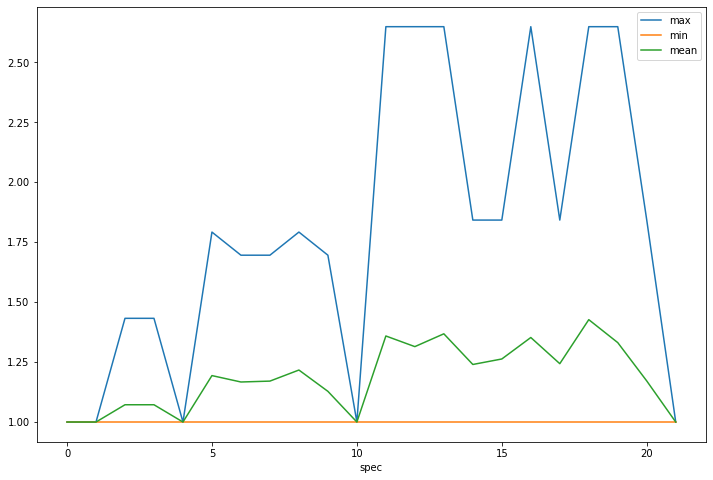

In [4]:
(comparison_squished["limit.tests"]/comparison_squished["real.tests"]).groupby("spec").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Specifications that fails to be approximated correctly

In [5]:
comparison_squished[comparison_squished["approx.tests"] < comparison_squished["real.tests"]]

,,real.tests,real.downs,size,clocks,approx.tests,approx.downs,limit.tests,limit.downs
spec,variant,,,,,,,,


### Raw limit vs real max percentage

<AxesSubplot:xlabel='spec,variant'>

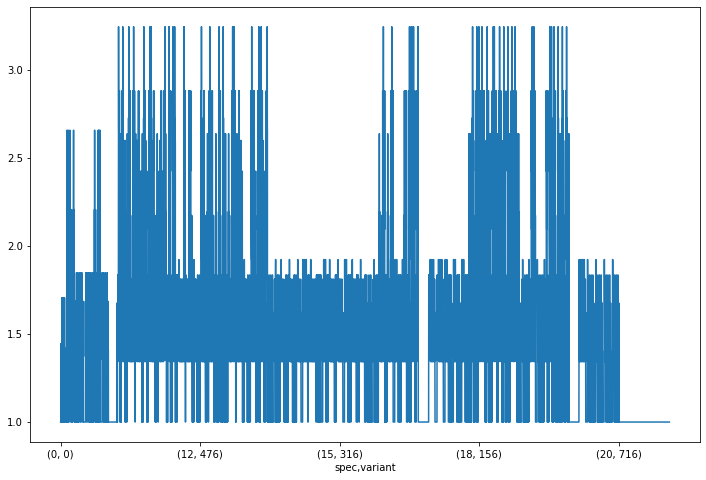

In [6]:
(comparison_squished["limit.downs"]/comparison_squished["real.downs"]).plot(figsize=(12,8))

In [7]:
opti_max = opti.groupby("spec").max()
real_statistics = real_max.groupby("spec").aggregate(["min", "max", "mean"])
compare = real_statistics.join(opti_max)
comparison_opti = compare.compute()

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


### Specification complexity range evolution (natural order)

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


<AxesSubplot:xlabel='spec'>

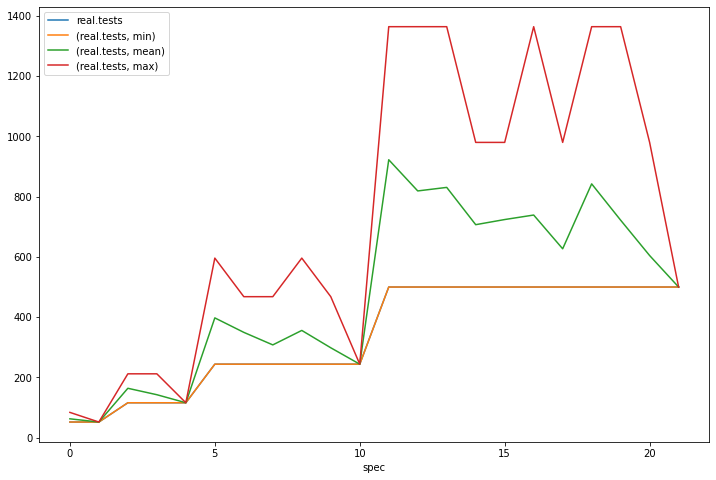

In [8]:
comparison_opti[["real.tests", ("real.tests", "min"), ("real.tests", "mean"), ("real.tests", "max")]].plot(figsize=(12, 8))

### Specification complexity range evolution (size)

<AxesSubplot:xlabel='size', ylabel='diff'>

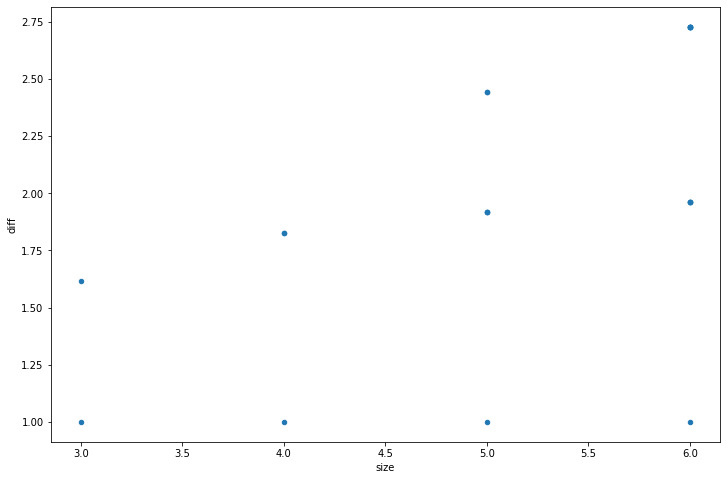

In [9]:
comparison_opti2 = comparison_opti.sort_values(("clocks", "max"))
comparison_opti2["diff"] = comparison_opti2[("real.tests", "max")]/comparison_opti2[("real.tests", "min")]
comparison_opti2["size"] = comparison_opti2[("size","max")]
comparison_opti2["clocks"] = comparison_opti2[("clocks","max")]
comparison_opti2.sort_values("size").plot.scatter(x="size", y="diff",figsize=(12, 8))

<AxesSubplot:xlabel='clocks', ylabel='diff'>

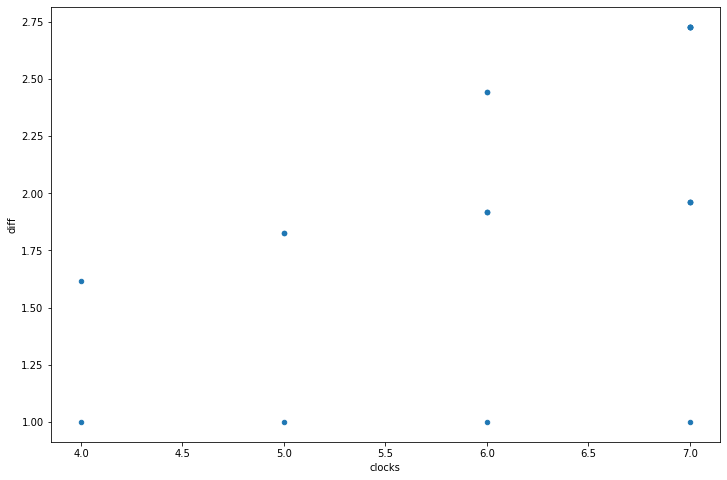

In [10]:
comparison_opti2.sort_values("clocks").plot.scatter(x="clocks", y="diff",figsize=(12, 8))

### All failed to optimize specifications

In [11]:
comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]]


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,comb,real.tests,real.downs
spec,,,,,,,,,,,,,,,,


### Percentage of badly optimized specifications

In [12]:
len(comparison_opti[comparison_opti["real.tests"] > comparison_opti[("real.tests", "mean")]])/len(comparison_opti)

0.0

### Scatter plot of permutations' real test values for each specification

<AxesSubplot:xlabel='spec', ylabel='real.tests'>

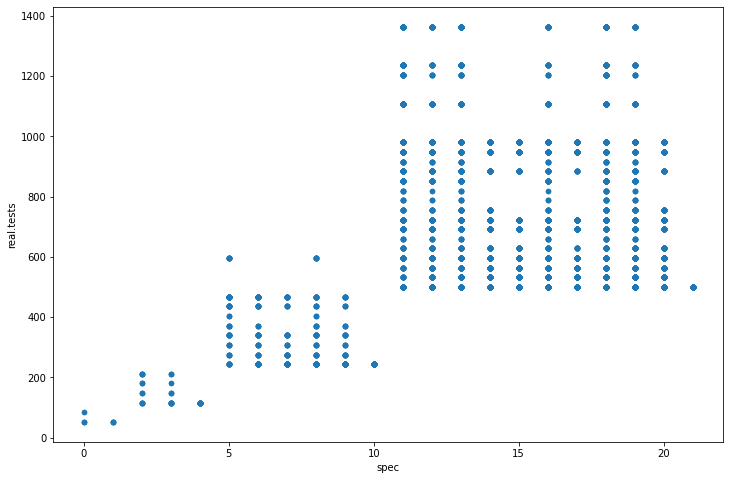

In [13]:
frame = real_max.compute()
frame.reset_index(inplace=True)
frame.plot.scatter(x="spec", y="real.tests", figsize=(12, 8))

### Relative scatter plot

In [14]:
relative_dist = real_max.compute().reset_index(level="variant").join(real_statistics.compute(), on="spec")
relative_dist

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)"
spec,,,,,,,,,,,,,,,,,
0,0,52,28,3,4,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0
0,1,52,28,3,4,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0
0,2,52,28,3,4,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0
0,3,84,36,3,4,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0
0,4,52,28,3,4,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,715,500,252,6,7,500,500,500.000000,252,252,252.000000,6,6,6.0,7,7,7.0
21,716,500,252,6,7,500,500,500.000000,252,252,252.000000,6,6,6.0,7,7,7.0
21,717,500,252,6,7,500,500,500.000000,252,252,252.000000,6,6,6.0,7,7,7.0


In [15]:
def scale_reals(row):
    new_rows = dict()
    test_min = row[("real.tests", "min")]
    test_max = row[("real.tests", "max")]
    if test_max == test_min:
        new_rows["rel_tests"] = 0
    else:
        new_rows["rel_tests"] = (row["real.tests"] - test_min) / (test_max - test_min)
    down_min = row[("real.downs", "min")]
    down_max = row[("real.downs", "max")]
    if down_min == down_max:
        new_rows["rel_downs"] = 0
    else:
        new_rows["rel_downs"] = (row["real.downs"] - down_min) / (down_max - down_min)
    new_rows["size"] = row["size"]
    new_rows["clocks"] = row["clocks"]
    return new_rows
relative_dist = relative_dist.apply(scale_reals, axis=1, result_type='expand')
relative_dist

,rel_tests,rel_downs,size,clocks
spec,,,,
0,0.0,0.0,3.0,4.0
0,0.0,0.0,3.0,4.0
0,0.0,0.0,3.0,4.0
0,1.0,1.0,3.0,4.0
0,0.0,0.0,3.0,4.0
...,...,...,...,...
21,0.0,0.0,6.0,7.0
21,0.0,0.0,6.0,7.0
21,0.0,0.0,6.0,7.0


In [16]:
relative_dist4 = relative_dist[relative_dist["size"] == 4]

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

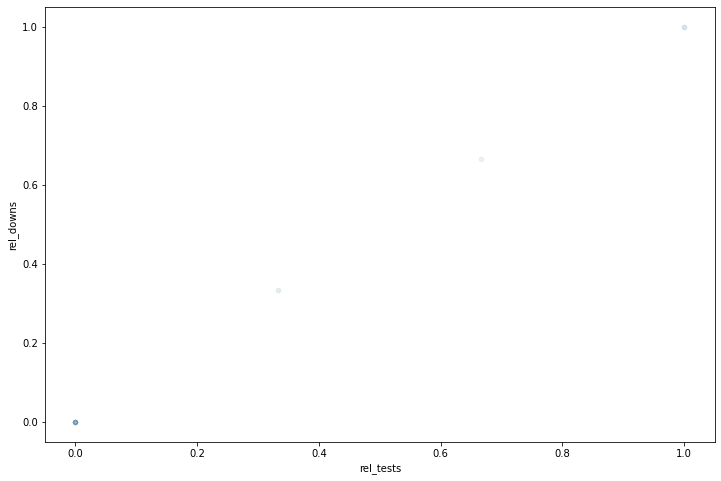

In [17]:
relative_dist4.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.01, figsize=(12, 8))


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

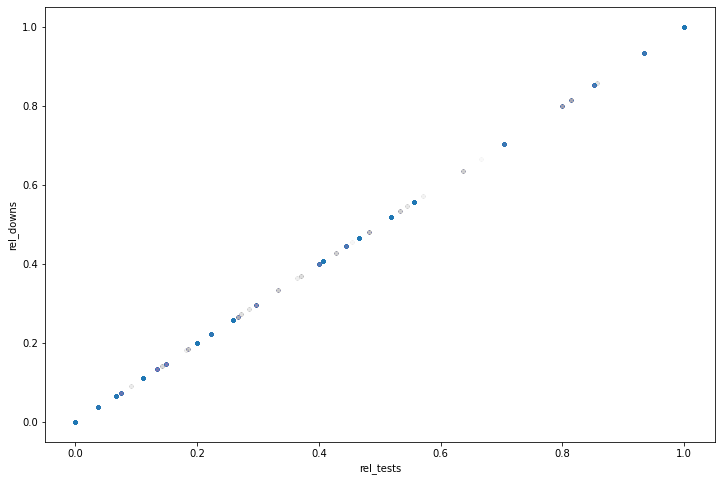

In [18]:
relative_dist.plot.scatter(x="rel_tests", y="rel_downs", alpha=0.005, figsize=(12, 8))


In [19]:
num_points = relative_dist.groupby("spec").aggregate(len).sort_values("rel_tests")

<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

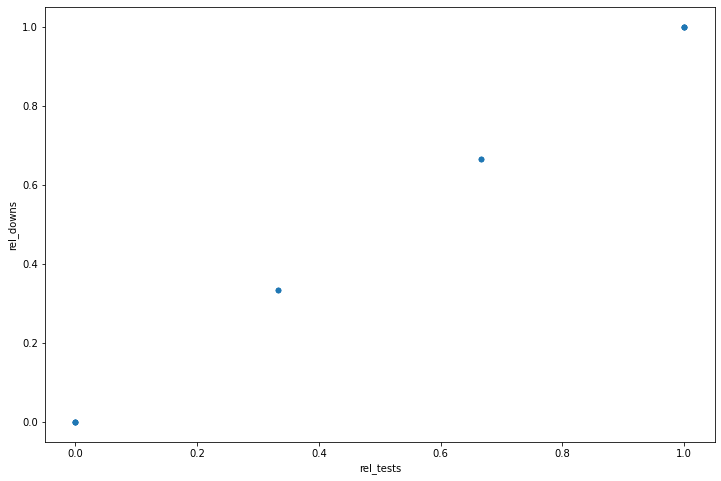

In [20]:
relative_dist.loc[num_points.index[2]].plot.scatter(x="rel_tests", y="rel_downs", figsize=(12, 8))


In [21]:
import os

all_methods_comp = real_statistics
methods = []
for file in os.listdir(dir+"/opti"):
     filename = os.fsdecode(file)
     if filename.endswith(".parquet"):
         table = dd.read_parquet(dir+"opti/"+filename, index=["spec"],columns=["real.tests"])
         table = table.groupby("spec").max()
         method = filename.replace(".parquet", "")
         table = table.rename(columns={"real.tests": method})
         methods.append(method)
         all_methods_comp = all_methods_comp.join(table)
     else:
         continue
all_methods_comp = all_methods_comp.compute()
all_methods_comp

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)",...,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
0,52,84,62.666667,28,36,30.666667,3,3,3.0,4,...,52,52,52,52,52,52,52,52,52,52
1,52,52,52.000000,28,28,28.000000,3,3,3.0,4,...,52,52,52,52,52,52,52,52,52,52
2,116,212,164.000000,60,84,72.000000,4,4,4.0,5,...,212,116,116,116,116,116,116,116,116,116
3,116,212,142.666667,60,84,66.666667,4,4,4.0,5,...,116,116,116,116,116,116,116,116,116,116
4,116,116,116.000000,60,60,60.000000,4,4,4.0,5,...,116,116,116,116,116,116,116,116,116,116
5,244,596,397.600000,124,212,162.400000,5,5,5.0,6,...,596,244,244,244,244,244,244,244,244,244
6,244,468,349.600000,124,180,150.400000,5,5,5.0,6,...,340,244,244,244,244,244,244,244,244,244
7,244,468,308.000000,124,180,140.000000,5,5,5.0,6,...,340,244,244,244,244,244,244,244,244,244
8,244,596,356.000000,124,212,152.000000,5,5,5.0,6,...,372,244,244,244,244,244,244,244,244,244


In [22]:
def diffs(row):
    new_row = dict()
    mean = row[("real.tests", "mean")]
    for i,c in enumerate(methods, start=1):
        new_row[c] = int(row[c] < mean or row[("real.tests", "min")] == row[("real.tests", "max")])
    return new_row
diffs_comp = all_methods_comp.copy()
diffs_comp = diffs_comp.apply(diffs, axis=1, result_type='expand')
diffs_comp

,sort_min_weights,tricost.dijkstra,init_weights.dijkstra,networkx.min_front,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,0,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,0,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,0,1,1,1,1,1,1,1,1,1
8,1,1,1,1,0,1,1,1,1,1,1,1,1,1


### Percentage of good optimized specifications by method

In [23]:
diffs_comp.apply(sum, axis=0).sort_values(ascending=False)/len(diffs_comp)

sort_min_weights          1.000000
tricost.dijkstra          1.000000
init_weights.dijkstra     1.000000
networkx.min_front        1.000000
networkx.dijkstra         1.000000
min_out.dijkstra          1.000000
min_out.tree_depth        1.000000
random.min_front          1.000000
init_weights.min_front    1.000000
min_out.tree_width        1.000000
tricost.min_front         1.000000
min_out.min_front         1.000000
random.dijkstra           1.000000
random                    0.727273
dtype: float64

### Visualisation of optimization coverage

<AxesSubplot:xlabel='spec'>

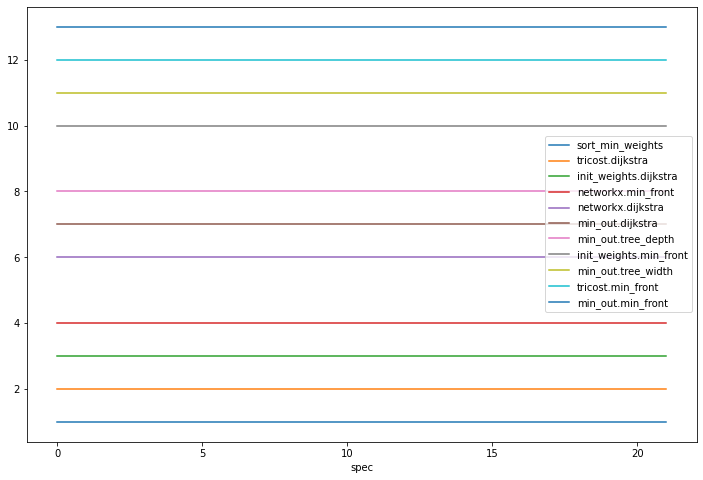

In [24]:
def scale_methods(row):
    new_row = dict()
    for i,c in enumerate(methods, start=1):
        if "random" in c:
            continue
        new_row[c] = i*row[c]
    return new_row
without_rand = diffs_comp.apply(scale_methods, axis=1, result_type='expand')
without_rand.iloc[:100].plot(figsize=(12, 8))

### Cumulative coverage

<AxesSubplot:xlabel='spec'>

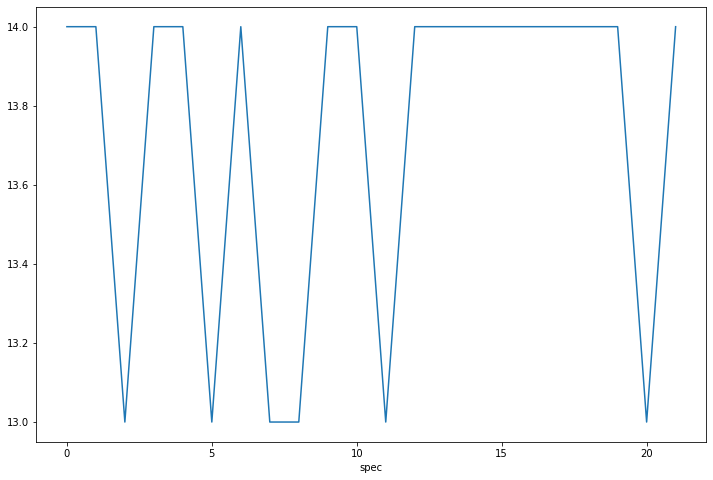

In [25]:
cumulative_comp = diffs_comp.apply(sum, axis=1)
cumulative_comp.plot(figsize=(12, 8))

### Uncovered specifications

In [26]:
cumulative_comp[cumulative_comp == 0]

Series([], dtype: int64)

In [27]:
starting = real_max.compute().reset_index(level="variant")
starting = starting[starting["variant"] == 0]
gain = starting.join(all_methods_comp)
gain = gain[(gain[("real.tests", "max")]/gain[("real.tests", "min")])>1.05]
gain

,variant,real.tests,real.downs,size,clocks,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)",...,random,networkx.dijkstra,min_out.dijkstra,min_out.tree_depth,random.min_front,init_weights.min_front,min_out.tree_width,tricost.min_front,min_out.min_front,random.dijkstra
spec,,,,,,,,,,,,,,,,,,,,,
0,0,52,28,3,4,52,84,62.666667,28,36,...,52,52,52,52,52,52,52,52,52,52
2,0,116,60,4,5,116,212,164.000000,60,84,...,212,116,116,116,116,116,116,116,116,116
3,0,116,60,4,5,116,212,142.666667,60,84,...,116,116,116,116,116,116,116,116,116,116
5,0,244,124,5,6,244,596,397.600000,124,212,...,596,244,244,244,244,244,244,244,244,244
6,0,244,124,5,6,244,468,349.600000,124,180,...,340,244,244,244,244,244,244,244,244,244
7,0,244,124,5,6,244,468,308.000000,124,180,...,340,244,244,244,244,244,244,244,244,244
8,0,244,124,5,6,244,596,356.000000,124,212,...,372,244,244,244,244,244,244,244,244,244
9,0,244,124,5,6,244,468,298.400000,124,180,...,244,244,244,244,244,244,244,244,244,244
11,0,500,252,6,7,500,1364,922.400000,252,468,...,980,500,500,500,500,500,500,500,500,500


### Gain in percentage relative to input specification

<AxesSubplot:ylabel='Frequency'>

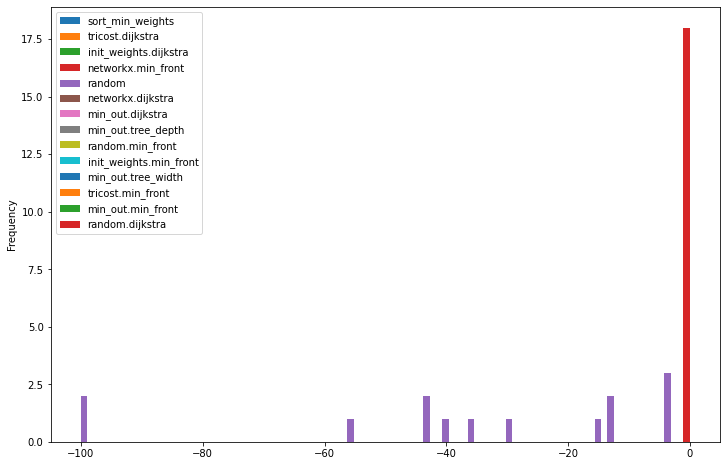

In [28]:
def gains_minus_start(row):
    new_row = dict()
    real = float(row["real.tests"])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (real - float(row[c])) / diff * 100
    return new_row
gain_from_start = gain.apply(gains_minus_start, axis=1, result_type='expand')
gain_from_start.plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain in percentage relative to input specification (specific method)

<AxesSubplot:ylabel='Frequency'>

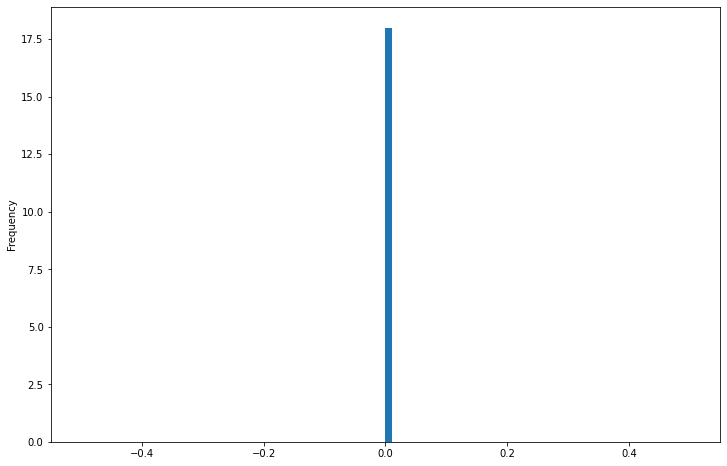

In [29]:
gain_from_start["init_weights.dijkstra"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### What are the 0 specs?

In [30]:
strange_0_specs = gain_from_start[["init_weights.min_front", ]][gain_from_start["init_weights.min_front"] == 0]
strange_0_specs = strange_0_specs.join(real_statistics.compute()).join(starting)
strange_0_specs

/home/paulra/Code/ccsl-rs/plotter/venv/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,init_weights.min_front,"(real.tests, min)","(real.tests, max)","(real.tests, mean)","(real.downs, min)","(real.downs, max)","(real.downs, mean)","(size, min)","(size, max)","(size, mean)","(clocks, min)","(clocks, max)","(clocks, mean)",variant,real.tests,real.downs,size,clocks
spec,,,,,,,,,,,,,,,,,,
0,0.0,52,84,62.666667,28,36,30.666667,3,3,3.0,4,4,4.0,0,52,28,3,4
2,0.0,116,212,164.000000,60,84,72.000000,4,4,4.0,5,5,5.0,0,116,60,4,5
3,0.0,116,212,142.666667,60,84,66.666667,4,4,4.0,5,5,5.0,0,116,60,4,5
5,0.0,244,596,397.600000,124,212,162.400000,5,5,5.0,6,6,6.0,0,244,124,5,6
6,0.0,244,468,349.600000,124,180,150.400000,5,5,5.0,6,6,6.0,0,244,124,5,6
7,0.0,244,468,308.000000,124,180,140.000000,5,5,5.0,6,6,6.0,0,244,124,5,6
8,0.0,244,596,356.000000,124,212,152.000000,5,5,5.0,6,6,6.0,0,244,124,5,6
9,0.0,244,468,298.400000,124,180,137.600000,5,5,5.0,6,6,6.0,0,244,124,5,6
11,0.0,500,1364,922.400000,252,468,357.600000,6,6,6.0,7,7,7.0,0,500,252,6,7


<AxesSubplot:xlabel='rel_tests', ylabel='rel_downs'>

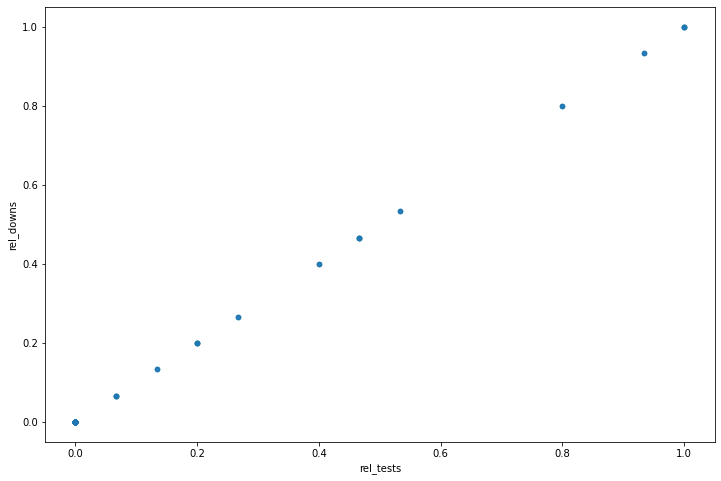

In [31]:
if len(strange_0_specs) != 0:
    relative_dist.loc[strange_0_specs.index[-1]].plot.scatter(x="rel_tests", y="rel_downs", alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<ipython-input-32-153d71a31a5b>:7: RuntimeWarning: invalid value encountered in double_scalars
  new_row[c] = (mean - float(row[c])) / diff * 100


<AxesSubplot:ylabel='Frequency'>

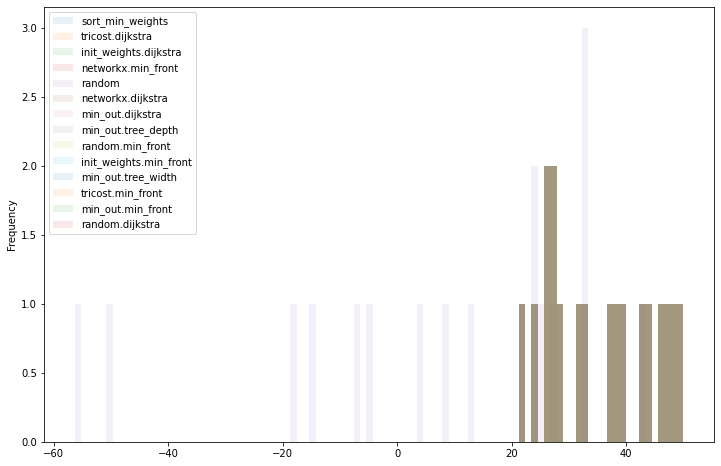

In [32]:
def gains_from_mean(row):
    new_row = dict()
    mean = float(row[("real.tests", "mean")])

    diff = (row[("real.tests", "max")] - row[("real.tests", "min")])
    for c in methods:
        new_row[c] = (mean - float(row[c])) / diff * 100
    return new_row
gain_from_mean = all_methods_comp.apply(gains_from_mean, axis=1, result_type='expand')
gain_from_mean.plot.hist(bins=96, alpha=0.1,figsize=(12, 8))

### Gain in percentage relative to mean

<AxesSubplot:ylabel='Frequency'>

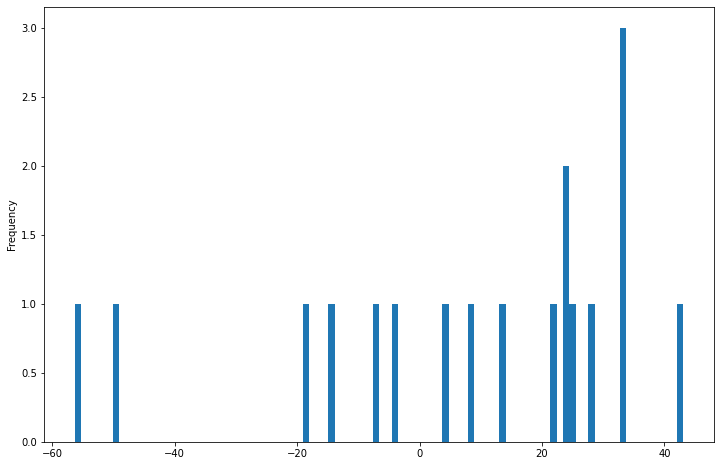

In [33]:
gain_from_mean["random"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

<AxesSubplot:ylabel='Frequency'>

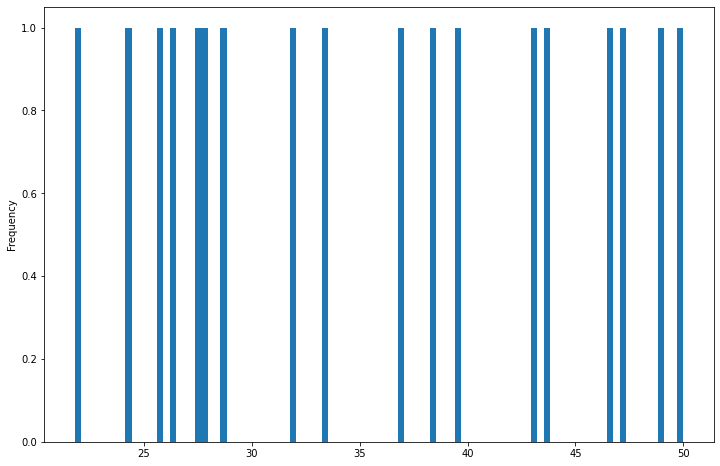

In [34]:
gain_from_mean["init_weights.dijkstra"].plot.hist(bins=96, alpha=1,figsize=(12, 8))

### Gain characteristics per method

In [35]:
gain_from_mean.aggregate(["mean", "std"], axis=0).transpose().sort_values("mean", ascending=False)

,mean,std
sort_min_weights,35.644594,9.331184
tricost.dijkstra,35.644594,9.331184
init_weights.dijkstra,35.644594,9.331184
networkx.min_front,35.644594,9.331184
networkx.dijkstra,35.644594,9.331184
min_out.dijkstra,35.644594,9.331184
min_out.tree_depth,35.644594,9.331184
random.min_front,35.644594,9.331184
init_weights.min_front,35.644594,9.331184
min_out.tree_width,35.644594,9.331184


### Complexity grow speed (by clocks)

<AxesSubplot:xlabel='clocks'>

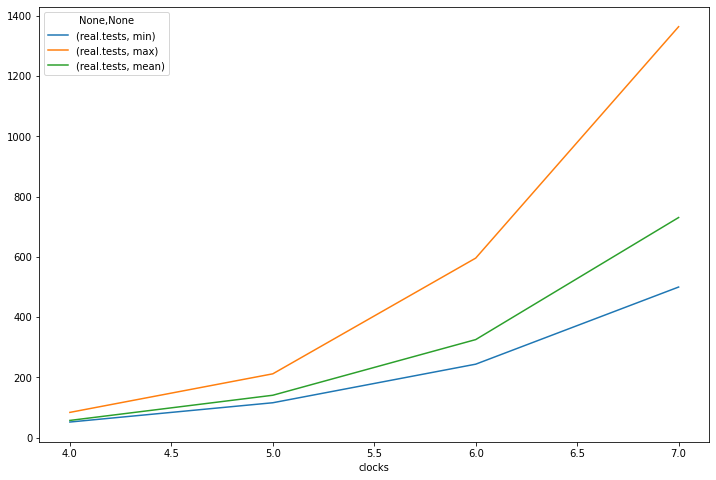

In [36]:
real_max[["clocks", "real.tests"]].groupby("clocks").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

### Complexity grow speed (by size)

<AxesSubplot:xlabel='size'>

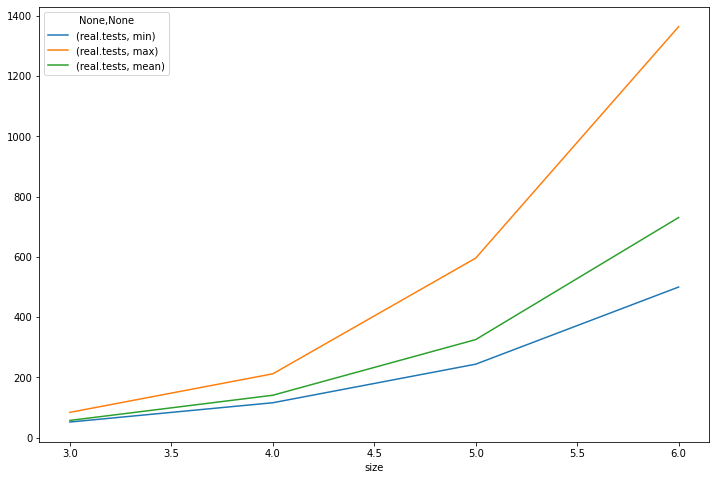

In [37]:
real_max[["size", "real.tests"]].groupby("size").aggregate(["min", "max", "mean"]).compute().plot(figsize=(12, 8))

In [38]:
comparison_size_clock = comparison_squished.copy()
comparison_size_clock["approx.tests"] = comparison_size_clock["approx.tests"].astype(np.int64)
comparison_size_clock["diff_appr_real"] = ((comparison_size_clock["approx.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock["diff_limit_real"] = ((comparison_size_clock["limit.tests"]-comparison_size_clock["real.tests"])/comparison_size_clock["real.tests"])
comparison_size_clock

real.tests  real.downs  size  clocks  approx.tests  \
spec variant                                                       
0    0                52          28     3       4            52   
     1                52          28     3       4            52   
     2                52          28     3       4            52   
     3                84          36     3       4            84   
     4                52          28     3       4            52   
...                  ...         ...   ...     ...           ...   
21   715             500         252     6       7           500   
     716             500         252     6       7           500   
     717             500         252     6       7           500   
     718             500         252     6       7           500   
     719             500         252     6       7           500   

              approx.downs  limit.tests  limit.downs  diff_appr_real  \
spec variant                                                           
0    0                  28           52           28             0.0   
     1                  28           52           28             0.0   
     2                  28           52           28             0.0   
     3                  52           84           52             0.0   
     4                  28           52           28             0.0   
...                    ...          ...          ...             ...   
21   715               252          500          252             0.0   
     716               252          500          252             0.0   
     717               252          500          252             0.0   
     718               252          500          252             0.0   
     719               252          500          252             0.0   

              diff_limit_real  
spec variant                   
0    0                    0.0  
     1                    0.0  
     2                    0.0  
     3                    0.0  
     4                    0.0  
...                       ...  
21   715                  0.0  
     716                  0.0  
     717                  0.0  
     718                  0.0  
     719                  0.0  

[8724 rows x 10 columns]

In [39]:
comparison_size_clock.groupby("size").aggregate("count")
comparison_size_clock.groupby("clocks").aggregate("count")


,real.tests,real.downs,clocks,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
size,,,,,,,,,
3,12,12,12,12,12,12,12,12,12
4,72,72,72,72,72,72,72,72,72
5,720,720,720,720,720,720,720,720,720
6,7920,7920,7920,7920,7920,7920,7920,7920,7920


,real.tests,real.downs,size,approx.tests,approx.downs,limit.tests,limit.downs,diff_appr_real,diff_limit_real
clocks,,,,,,,,,
4,12,12,12,12,12,12,12,12,12
5,72,72,72,72,72,72,72,72,72
6,720,720,720,720,720,720,720,720,720
7,7920,7920,7920,7920,7920,7920,7920,7920,7920


### Growth speed of difference of real and approximate complexities (by size)

<AxesSubplot:xlabel='size'>

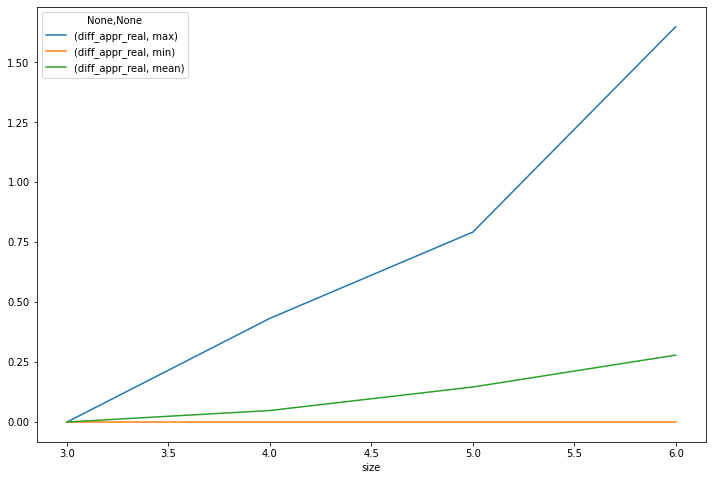

In [40]:
comparison_size_clock[["size", "diff_appr_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='size'>

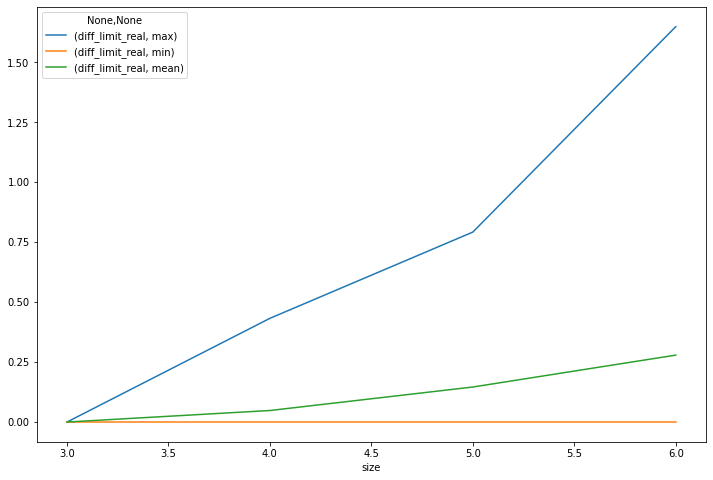

In [41]:
comparison_size_clock[["size", "diff_limit_real"]].groupby("size").agg(["max", "min", "mean"]).plot(figsize=(12,8))


### Growth speed of difference of real and approximate complexities (by clock)

<AxesSubplot:xlabel='clocks'>

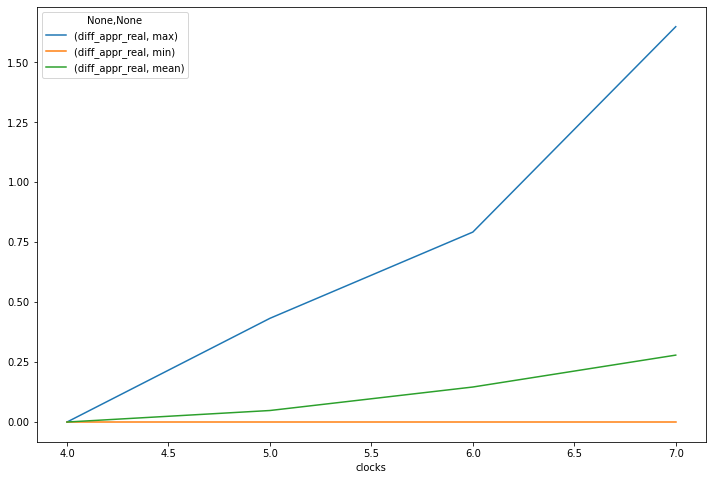

In [42]:
comparison_size_clock[["clocks", "diff_appr_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

<AxesSubplot:xlabel='clocks'>

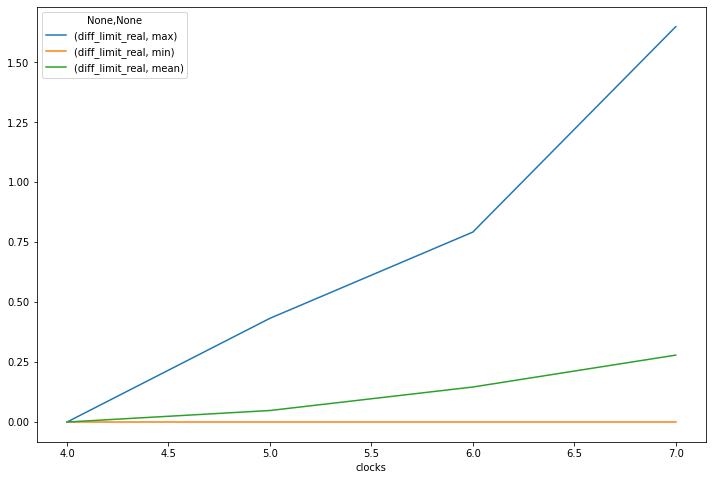

In [43]:
comparison_size_clock[["clocks", "diff_limit_real"]].groupby("clocks").agg(["max", "min", "mean"]).plot(figsize=(12,8))

### Check if approximations allow specification comparison

In [44]:
check_order = comparison_squished[["real.tests", "approx.tests"]].reset_index(level="variant").drop("variant", axis=1).groupby("spec").aggregate(list)
check_order

,real.tests,approx.tests
spec,,
0,"[52, 52, 52, 84, 52, 84]","[52, 52, 52, 84, 52, 84]"
1,"[52, 52, 52, 52, 52, 52]","[52, 52, 52, 52, 52, 52]"
2,"[116, 180, 116, 116, 212, 148, 116, 180, 148, ...","[116, 180, 116, 116, 212, 212, 116, 180, 212, ..."
3,"[116, 116, 116, 116, 116, 116, 116, 116, 148, ...","[116, 116, 116, 116, 116, 116, 116, 116, 212, ..."
4,"[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[116, 116, 116, 116, 116, 116, 116, 116, 116, ..."
5,"[244, 372, 244, 244, 436, 308, 276, 404, 340, ...","[244, 372, 244, 244, 436, 436, 468, 724, 468, ..."
6,"[244, 372, 244, 244, 436, 308, 244, 372, 244, ...","[244, 372, 244, 244, 436, 436, 244, 372, 244, ..."
7,"[244, 244, 244, 244, 244, 244, 244, 244, 244, ...","[244, 244, 244, 244, 244, 244, 244, 244, 244, ..."
8,"[244, 244, 308, 436, 244, 372, 244, 244, 244, ...","[244, 244, 436, 436, 244, 372, 244, 244, 244, ..."


In [45]:
def order_holds(orig: List[int], aprox: List[int]) -> float:
    candidates = list(zip(orig, aprox))
    hold_times = 0
    count = 0
    for (lorig, laprox), (rorig, raprox) in combinations(candidates, 2):
        ok = (lorig < rorig and laprox < raprox) or \
          (lorig > rorig and laprox > raprox) or \
          (lorig == rorig and laprox == raprox)
        hold_times += int(ok)
        count +=1
    return hold_times/count

check_order["holds"] = check_order.apply(lambda row: order_holds(row["real.tests"], row["approx.tests"]), axis=1)
check_order.holds.mean()

0.8158428437773508